In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('portfolio.csv')
data

,Date,ACB,VIX,MBB,GMD,HDB
0,5/4/2020,8340,1730,7230,15880,6900
1,5/5/2020,8340,1660,7210,15880,6940
2,5/6/2020,8550,1700,7280,15880,6860
3,5/7/2020,8720,1700,7430,16149,6830
4,5/8/2020,8800,1700,7570,16059,7170
...,...,...,...,...,...,...
953,3/19/2024,26850,19300,23200,77000,22350
954,3/20/2024,27500,20000,24150,78000,22600
955,3/21/2024,28000,20150,24750,78400,23900
956,3/22/2024,28150,20150,25050,78600,23800


In [3]:
def process_data(df):
    # Kiểm tra xem cột 'Date' tồn tại trong DataFrame không
    if 'Date' in df.columns:
        # Chuyển đổi cột 'Date' sang kiểu datetime
        df['Date'] = pd.to_datetime(df['Date'])
        # Đặt cột 'Date' làm chỉ số
        df.set_index('Date', inplace=True)
        # Chia các giá trị trong cột 'ACB' và 'CTG' cho 1000
        df['ACB'] /= 1000
        df['VIX'] /= 1000
        df['MBB'] /= 1000
        df['GMD'] /= 1000
        df['HDB'] /= 1000
        return df
    else:
        print("Không tìm thấy cột 'Date' trong DataFrame.")
data = process_data(data)

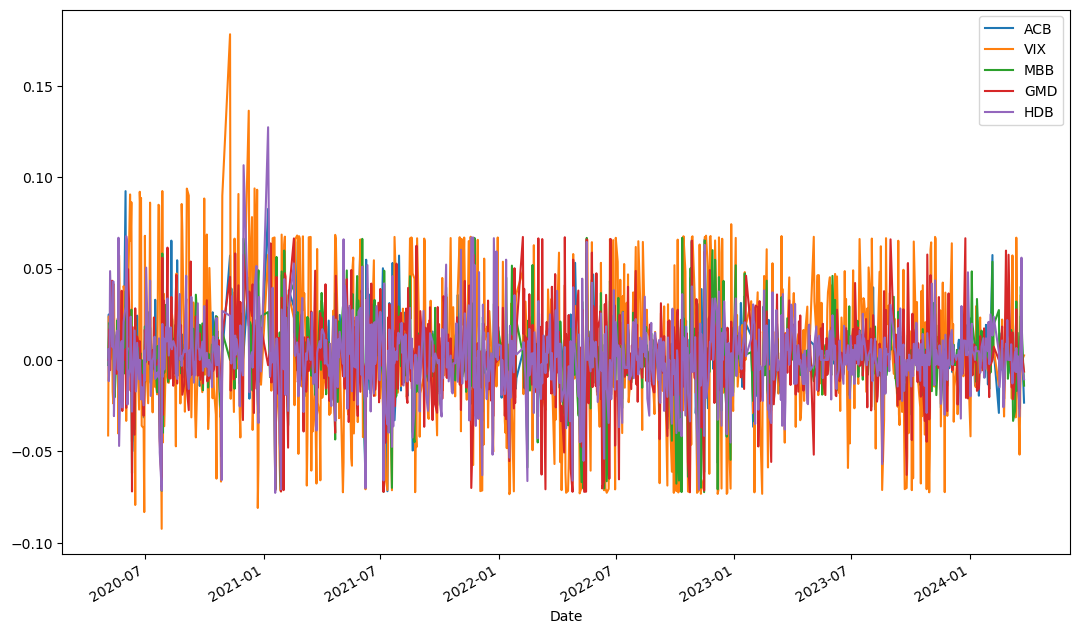

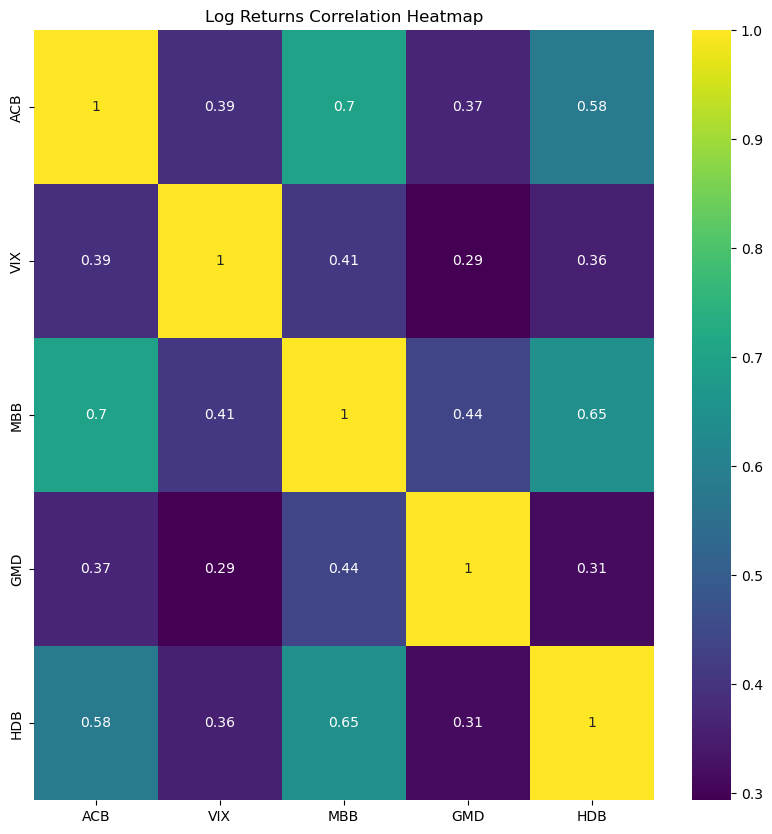

In [4]:
daily_log_returns = np.log(data) - np.log(data.shift(1))
daily_log_returns.plot(figsize=(13, 8))
corr = daily_log_returns.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="viridis")
plt.title('Log Returns Correlation Heatmap')
plt.show()

In [5]:
tickers = ['ACB', 'VIX', 'MBB', 'GMD', 'HDB']
stocks = len(tickers)
weights = np.full((stocks,), 1 / stocks)

C:\Users\Lenovo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


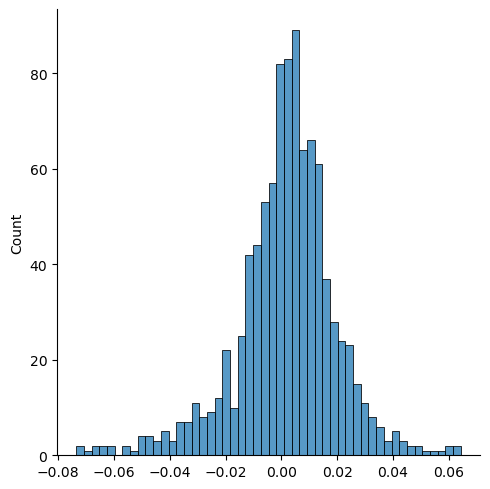

In [6]:
daily_portfolio_returns = daily_log_returns.dot(weights)
sns.displot(daily_portfolio_returns, bins=50)

In [7]:
expected_return = daily_portfolio_returns.mean() * 252
vol = daily_portfolio_returns.std() * np.sqrt(252)
skew = daily_portfolio_returns.skew()
sr = expected_return / vol

print(f"{expected_return=}")
print(f"{vol=}")
print(f"{skew=}")
print(f"{sr=}")

expected_return=0.405505771116032
vol=0.28810801753145704
skew=-0.5729321582044417
sr=1.4074782596834774


In [12]:
returns = daily_log_returns
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * np.sqrt(252)

# Assuming 'tickers', 'mean_returns', and 'cov_matrix' are already defined
num_portfolios = 10000

# DataFrame to store the results
results = pd.DataFrame(columns=['returns', 'volatility', 'sharpe', 'weights'], index=range(num_portfolios))
# store all weights
weights_record = []

for i in range(num_portfolios):
		# Normalised randomly generated weights
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

		# Calculate returns and volatility
    returns = np.dot(weights, mean_returns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

		# Store results
    results.loc[i, 'returns'] = returns
    results.loc[i, 'volatility'] = volatility
    results.loc[i, 'sharpe'] = results.loc[i, 'returns'] / results.loc[i, 'volatility']
    results.loc[i, 'weights'] = ','.join(str(np.round(weight, 4)) for weight in weights)
		# record weights
    weights_record.append(weights)
    
print(results.sort_values('sharpe', ascending=False))

       returns volatility    sharpe                             weights
3069  0.427667   0.073622  5.808976  0.2251,0.2162,0.0038,0.3786,0.1763
4387  0.417894   0.071959  5.807384   0.2544,0.1922,0.0067,0.3608,0.186
8948  0.432146   0.074466  5.803262  0.1896,0.2216,0.0166,0.4036,0.1686
9502  0.429356   0.074026    5.8001  0.1907,0.2189,0.0414,0.3837,0.1652
8912  0.420556   0.072514  5.799685  0.2463,0.2024,0.0365,0.3533,0.1615
...        ...        ...       ...                                 ...
6998  0.323688   0.073289  4.416592  0.1148,0.0005,0.3562,0.0128,0.5156
3013  0.613736   0.139439  4.401483    0.047,0.8943,0.0065,0.0133,0.039
3620  0.324833    0.07402  4.388448  0.0554,0.0012,0.4849,0.0163,0.4422
3679  0.325212   0.074181  4.384047  0.2039,0.0005,0.0512,0.0377,0.7067
5597  0.340135   0.078383  4.339389  0.0385,0.0346,0.8486,0.0603,0.0179

[10000 rows x 4 columns]


In [13]:
# Efficient Frontier with max sharpe portfolio and min volatility portfolio
max_sharpe_portfolio = results.iloc[pd.to_numeric(results['sharpe']).idxmax()]
min_volatility_portfolio = results.iloc[pd.to_numeric(results['volatility']).idxmin()]

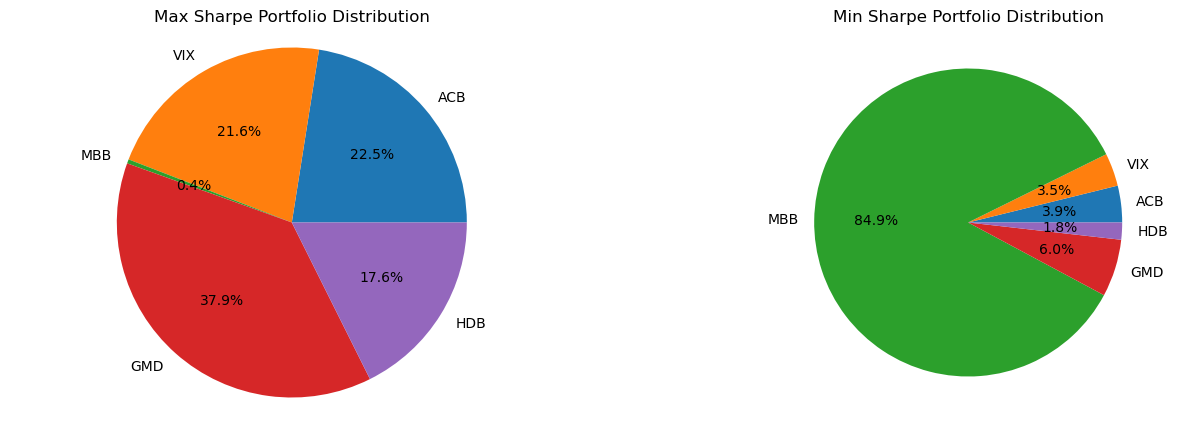

In [14]:
# Get rows with max and min 'sharpe' values
row_max = results.sort_values('sharpe', ascending=False).head(1)
row_min = results.sort_values('sharpe').head(1)

# Split the weights strings and convert to floats
weights_max = [float(x) for x in row_max['weights'].iloc[0].split(',')]
weights_min = [float(x) for x in row_min['weights'].iloc[0].split(',')]

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))  # 1 row, 2 columns

# Plotting the max sharpe pie chart
axs[0].pie(weights_max, labels=tickers, autopct='%1.1f%%')
axs[0].set_title('Max Sharpe Portfolio Distribution')
axs[0].axis('equal')  # Equal aspect ratio

# Plotting the min sharpe pie chart
axs[1].pie(weights_min, labels=tickers, autopct='%1.1f%%')
axs[1].set_title('Min Sharpe Portfolio Distribution')
plt.show()